# **Generating Vector Embeddings with OpenAi CLIP**

In [ ]:
!pip cache purge

In [ ]:
!pip install openpyxl
!pip install transformers
!pip install reportlab
! pip install pandas pillow imagehash openpyxl


In [ ]:
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install matplotlib --quiet
!pip install opencv-python-headless --quiet
!pip install torch torchvision torchaudio --quiet

In [8]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import cv2
import torch
from tqdm import tqdm
from PIL import Image as PILImage
import clip
import openpyxl

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def extract_frames(video_path, interval=1):
    """
    Extract frames from a video at a specified interval.
    Args:
        video_path (str): Path to the video file.
        interval (int): Interval in seconds between frames.
    Returns:
        list: List of frames (numpy arrays).
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    if not frame_rate:
        return frames
    target_frame_index = 0
    while cap.isOpened():
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        target_frame_index += int(frame_rate * interval)
    cap.release()
    return frames

def generate_embedding(frame):
    """
    Generate an embedding for a single frame using CLIP.
    Args:
        frame (numpy array): Frame image as numpy array.
    Returns:
        numpy array: Frame embedding.
    """
    frame_tensor = preprocess(PILImage.fromarray(frame)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(frame_tensor).cpu().numpy()
    return embedding[0]

def process_video(video_url):
    """
    Download a video, extract frames, and compute a single embedding.
    Args:
        video_url (str): URL of the video.
    Returns:
        numpy array: Video embedding (average of frame embeddings).
    """
    try:
        video_path = os.path.basename(video_url)
        if not os.path.exists(video_path):
            with open(video_path, 'wb') as f:
                f.write(requests.get(video_url).content)

        frames = extract_frames(video_path)
        if not frames:
            return None

        embeddings = [generate_embedding(frame) for frame in frames]

        video_embedding = np.mean(embeddings, axis=0)
        return video_embedding / np.linalg.norm(video_embedding)
    except Exception as e:
        print(f"Error processing video {video_url}: {e}")
        return None

def process_excel(input_file, output_file):
    """
    Process an Excel file with video links, generating embeddings for each video.
    Args:
        input_file (str): Path to input Excel file.
        output_file (str): Path to save the processed Excel file.
    """
    df = pd.read_excel(input_file)

    if "Video URL" not in df.columns:
        print("No 'Video URL' column found in the Excel file.")
        return

    embeddings = []
    for video_url in tqdm(df["Video URL"], desc="Processing videos"):
        embedding = process_video(video_url)
        embeddings.append(embedding)

    df["video_embedding"] = embeddings

    df.to_excel(output_file, index=False)
    print(f"Processed file saved to {output_file}")

if __name__ == "__main__":
    input_excel = "Copy of Assignment Data_up1.xlsx"  # Input file path
    output_excel = "video_embeddings_up_30.xlsx"  # Output file path
    process_excel(input_excel, output_excel)


Processing videos: 100%|██████████| 268/268 [25:00<00:00,  5.60s/it]


Processed file saved to video_embeddings_up_30.xlsx


In [ ]:
# ! rm -rf hd*

# **Clustering videos based on vector embeddings**

In [ ]:
df1=pd.read_excel("/content/Assignment Data.xlsx")
df2=pd.read_excel("/content/video_embeddings_up_30.xlsx")
df2.drop('Performance',axis=1,inplace=True)

merged_df = pd.merge(df1, df2, on='Video URL', how='inner')
merged_df.head()
merged_df.to_excel('merged_data.xlsx', index=False)

In [ ]:
df3=pd.read_excel("/content/merged_data.xlsx")

In [ ]:

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans


df3['first_line_embedding'] = df3['video_embedding'].str.split('\n').str[0]
df3['first_line_embedding']=df3['first_line_embedding'].str.replace(' ','')
df3['first_line_embedding']=df3['first_line_embedding'].str.replace('[','')


unique_embeddings = df3['first_line_embedding'].unique()
embedding_to_cluster = {value: idx for idx, value in enumerate(unique_embeddings)}

df3['cluster_label'] = df3['first_line_embedding'].map(embedding_to_cluster)

df3[['Performance','Video URL', 'first_line_embedding', 'cluster_label']].to_excel("clustered_videos_exact_match_up.xlsx", index=False)

print("Clustering based on exact match completed. Results saved to 'clustered_videos_exact_match.xlsx'.")

# **Extract Influencer pics from each cluster of video**

In [ ]:
# ! rm -rf detected_objects/*

In [ ]:
import os
import cv2
import torch
import clip
import requests
import pandas as pd
from PIL import Image as PILImage
from tqdm import tqdm

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Frame Extraction Function
def extract_frames(video_path, interval=1):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    if not frame_rate:
        return frames
    target_frame_index = 0
    while cap.isOpened():
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        target_frame_index += int(frame_rate * interval)
    cap.release()
    return frames

def detect_objects_in_frame(frame, text_prompts):
    image_tensor = preprocess(PILImage.fromarray(frame)).unsqueeze(0).to(device)
    text_tokens = clip.tokenize(text_prompts).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_tokens)
        logits_per_image = image_features @ text_features.T
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    detected_objects = [text_prompts[i] for i, prob in enumerate(probs[0]) if prob > 0.1]
    return detected_objects

def save_detected_objects(frame, detections, output_dir, frame_idx):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for detection in detections:
        output_path = os.path.join(output_dir, f"{detection}_frame_{frame_idx}.jpg")
        cv2.imwrite(output_path, frame)

def process_video_for_objects(video_url, text_prompts, output_dir, frame_interval=1):
    try:
        video_path = os.path.basename(video_url)
        if not os.path.exists(video_path):
            with open(video_path, 'wb') as f:
                f.write(requests.get(video_url).content)

        frames = extract_frames(video_path, interval=frame_interval)
        if not frames:
            print(f"No frames extracted from {video_url}")
            return

        for idx, frame in tqdm(enumerate(frames), desc=f"Processing {output_dir}"):
            detections = detect_objects_in_frame(frame, text_prompts)
            if detections:
                save_detected_objects(frame, detections, output_dir, idx)

        print(f"Processing completed for {video_url}. Detected objects saved to {output_dir}.")
    except Exception as e:
        print(f"Error processing video {video_url}: {e}")

if __name__ == "__main__":
    excel_path = "one_row_per_cluster.xlsx"
    data = pd.read_excel(excel_path)


    text_prompts = [
       "man","woman"
    ]

    frame_interval = 1


    for _, row in data.iterrows():
        video_url = row["Video URL"]
        cluster_label = row["cluster_label"]
        output_dir = os.path.join("detected_objects", str(cluster_label))

        process_video_for_objects(video_url, text_prompts, output_dir, frame_interval)


Processing detected_objects/0: 14it [00:01,  7.26it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-999607261342550. Detected objects saved to detected_objects/0.


Processing detected_objects/1: 12it [00:01,  7.81it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-997580728807604. Detected objects saved to detected_objects/1.


Processing detected_objects/2: 21it [00:02,  7.53it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-992418235673669. Detected objects saved to detected_objects/2.


Processing detected_objects/3: 14it [00:01,  7.56it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-992064161877405. Detected objects saved to detected_objects/3.


Processing detected_objects/4: 19it [00:02,  7.38it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989969399547901. Detected objects saved to detected_objects/4.


Processing detected_objects/5: 21it [00:02,  7.41it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989930303148492. Detected objects saved to detected_objects/5.


Processing detected_objects/6: 11it [00:01,  7.22it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989654009083459. Detected objects saved to detected_objects/6.


Processing detected_objects/7: 26it [00:03,  7.65it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-987643572956494. Detected objects saved to detected_objects/7.


Processing detected_objects/8: 15it [00:01,  7.70it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-987287402378278. Detected objects saved to detected_objects/8.


Processing detected_objects/9: 12it [00:01,  7.62it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-986360206629277. Detected objects saved to detected_objects/9.


Processing detected_objects/10: 17it [00:02,  7.41it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-983335896508749. Detected objects saved to detected_objects/10.


Processing detected_objects/11: 17it [00:02,  7.50it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-975523146942238. Detected objects saved to detected_objects/11.


Processing detected_objects/12: 21it [00:02,  7.43it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-965108935263649. Detected objects saved to detected_objects/12.


Processing detected_objects/13: 14it [00:01,  8.22it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-964733417506862. Detected objects saved to detected_objects/13.


Processing detected_objects/14: 20it [00:02,  7.59it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-963303392509872. Detected objects saved to detected_objects/14.


Processing detected_objects/15: 13it [00:01,  7.56it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-960884234555681. Detected objects saved to detected_objects/15.


Processing detected_objects/16: 14it [00:01,  7.78it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-958774641659407. Detected objects saved to detected_objects/16.


Processing detected_objects/17: 26it [00:03,  7.58it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-954832972830686. Detected objects saved to detected_objects/17.


Processing detected_objects/18: 23it [00:03,  7.53it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-954440782897187. Detected objects saved to detected_objects/18.


Processing detected_objects/19: 12it [00:01,  7.73it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-951885082053340. Detected objects saved to detected_objects/19.


Processing detected_objects/20: 13it [00:01,  7.82it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-944981830978756. Detected objects saved to detected_objects/20.


Processing detected_objects/21: 27it [00:03,  7.33it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-942779243913664. Detected objects saved to detected_objects/21.


Processing detected_objects/22: 18it [00:02,  7.66it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-939795907980426. Detected objects saved to detected_objects/22.


Processing detected_objects/23: 16it [00:02,  7.35it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-938232524809973. Detected objects saved to detected_objects/23.


Processing detected_objects/24: 20it [00:02,  7.68it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-932703258597949. Detected objects saved to detected_objects/24.


Processing detected_objects/25: 19it [00:02,  7.37it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-929511878466995. Detected objects saved to detected_objects/25.


Processing detected_objects/26: 10it [00:01,  7.80it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-929300948587514. Detected objects saved to detected_objects/26.


Processing detected_objects/27: 21it [00:02,  7.90it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-925260332281638. Detected objects saved to detected_objects/27.


Processing detected_objects/28: 16it [00:02,  7.54it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-924865635226814. Detected objects saved to detected_objects/28.


Processing detected_objects/29: 15it [00:01,  8.31it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-620702145697389. Detected objects saved to detected_objects/29.


Processing detected_objects/30: 14it [00:01,  7.68it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-613197413789434. Detected objects saved to detected_objects/30.


Processing detected_objects/31: 18it [00:02,  8.25it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-604285914607200. Detected objects saved to detected_objects/31.


Processing detected_objects/32: 18it [00:02,  7.68it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-604041931565137. Detected objects saved to detected_objects/32.


Processing detected_objects/33: 21it [00:02,  8.14it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-603099807587246. Detected objects saved to detected_objects/33.


Processing detected_objects/34: 10it [00:01,  7.71it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-911926190614858. Detected objects saved to detected_objects/34.


Processing detected_objects/35: 14it [00:01,  7.93it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-906506897404894. Detected objects saved to detected_objects/35.


Processing detected_objects/36: 20it [00:02,  7.61it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-905739711170399. Detected objects saved to detected_objects/36.


Processing detected_objects/37: 16it [00:02,  7.37it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-904815481005158. Detected objects saved to detected_objects/37.


Processing detected_objects/38: 17it [00:02,  7.41it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-903913985069116. Detected objects saved to detected_objects/38.


Processing detected_objects/39: 21it [00:02,  7.75it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-902456848100089. Detected objects saved to detected_objects/39.


Processing detected_objects/40: 17it [00:02,  7.63it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-901695498551491. Detected objects saved to detected_objects/40.


Processing detected_objects/41: 19it [00:02,  7.54it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-894559812351386. Detected objects saved to detected_objects/41.


Processing detected_objects/42: 24it [00:03,  7.62it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-893539262677484. Detected objects saved to detected_objects/42.


Processing detected_objects/43: 18it [00:02,  7.92it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-888593019388197. Detected objects saved to detected_objects/43.


Processing detected_objects/44: 17it [00:02,  7.88it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-888183703182855. Detected objects saved to detected_objects/44.


Processing detected_objects/45: 21it [00:02,  7.81it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-887363366529815. Detected objects saved to detected_objects/45.


Processing detected_objects/46: 20it [00:02,  7.83it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-885670366433640. Detected objects saved to detected_objects/46.


Processing detected_objects/47: 19it [00:02,  7.71it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-885209946993560. Detected objects saved to detected_objects/47.


Processing detected_objects/48: 12it [00:01,  7.67it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-883738210384679. Detected objects saved to detected_objects/48.


Processing detected_objects/49: 17it [00:02,  7.55it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-882019143545185. Detected objects saved to detected_objects/49.


Processing detected_objects/50: 22it [00:02,  7.80it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-881342303358042. Detected objects saved to detected_objects/50.


Processing detected_objects/51: 20it [00:02,  7.48it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-880568190186256. Detected objects saved to detected_objects/51.


Processing detected_objects/52: 19it [00:02,  7.55it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-880340126836307. Detected objects saved to detected_objects/52.


Processing detected_objects/53: 17it [00:02,  7.38it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-879631723735807. Detected objects saved to detected_objects/53.


Processing detected_objects/54: 19it [00:02,  7.51it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-877210454387561. Detected objects saved to detected_objects/54.


Processing detected_objects/55: 25it [00:03,  7.47it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-876239523982490. Detected objects saved to detected_objects/55.


Processing detected_objects/56: 22it [00:02,  7.60it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-874864704574925. Detected objects saved to detected_objects/56.


Processing detected_objects/57: 13it [00:01,  7.58it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-871981848375866. Detected objects saved to detected_objects/57.


Processing detected_objects/58: 22it [00:02,  7.72it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-817763467176157. Detected objects saved to detected_objects/58.


Processing detected_objects/59: 14it [00:01,  7.57it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-814072014151046. Detected objects saved to detected_objects/59.


Processing detected_objects/60: 18it [00:02,  7.62it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-8111507755613955. Detected objects saved to detected_objects/60.


Processing detected_objects/61: 13it [00:01,  7.61it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-8100667816697710. Detected objects saved to detected_objects/61.


Processing detected_objects/62: 11it [00:01,  7.87it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-809480737932683. Detected objects saved to detected_objects/62.


Processing detected_objects/63: 18it [00:02,  7.89it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-806751788307038. Detected objects saved to detected_objects/63.


Processing detected_objects/64: 13it [00:01,  7.32it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-803990118540094. Detected objects saved to detected_objects/64.


Processing detected_objects/65: 19it [00:02,  7.89it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-803897110603133. Detected objects saved to detected_objects/65.


Processing detected_objects/66: 10it [00:01,  7.62it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-7995631707140182. Detected objects saved to detected_objects/66.


Processing detected_objects/67: 27it [00:03,  7.61it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-793257836073148. Detected objects saved to detected_objects/67.


Processing detected_objects/68: 22it [00:03,  7.29it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-6764280623620361. Detected objects saved to detected_objects/68.


Processing detected_objects/69: 13it [00:01,  7.63it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-6720438181324436. Detected objects saved to detected_objects/69.


Processing detected_objects/70: 15it [00:02,  7.36it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-671839840899900. Detected objects saved to detected_objects/70.


Processing detected_objects/71: 18it [00:02,  7.16it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-429145826826558. Detected objects saved to detected_objects/71.


Processing detected_objects/72: 23it [00:03,  7.52it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-425151876539382. Detected objects saved to detected_objects/72.


Processing detected_objects/73: 14it [00:01,  7.83it/s]


Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-1693566687752051. Detected objects saved to detected_objects/73.


Processing detected_objects/74: 27it [00:03,  7.50it/s]

Processing completed for https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-1119706949586170. Detected objects saved to detected_objects/74.


# **Detect Human Face in the extracted images using OpenCV Haar cascades**

In [ ]:
import os
import cv2
import json
from tqdm import tqdm

def detect_faces_in_image(image_path, face_cascade):
    """
    Detect human faces in an image using Haar cascade.
    Args:
        image_path (str): Path to the image file.
        face_cascade (cv2.CascadeClassifier): Pre-trained Haar cascade for face detection.
    Returns:
        bool: True if at least one face is detected, False otherwise.
    """
    image = cv2.imread(image_path)
    if image is None:
        return False
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return len(faces) > 0

def list_images_with_faces(cluster_dir, face_cascade):
    """
    List all images containing human faces in a given cluster directory.
    Args:
        cluster_dir (str): Path to the cluster directory.
        face_cascade (cv2.CascadeClassifier): Pre-trained Haar cascade for face detection.
    Returns:
        list: List of image filenames containing faces.
    """
    images_with_faces = []
    for image_name in tqdm(os.listdir(cluster_dir), desc=f"Processing {os.path.basename(cluster_dir)}"):
        image_path = os.path.join(cluster_dir, image_name)
        if os.path.isfile(image_path) and detect_faces_in_image(image_path, face_cascade):
            images_with_faces.append(image_name)
    return images_with_faces

def main():

    root_dir = "detected_objects"


    haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(haar_cascade_path)


    cluster_faces = {}


    for cluster_name in os.listdir(root_dir):
        cluster_dir = os.path.join(root_dir, cluster_name)
        if os.path.isdir(cluster_dir):
            images_with_faces = list_images_with_faces(cluster_dir, face_cascade)
            cluster_faces[cluster_name] = images_with_faces

    output_file = "faces_in_clusters.json"
    with open(output_file, "w") as f:
        json.dump(cluster_faces, f, indent=4)

    print(f"Face detection completed. Results saved to {output_file}.")

if __name__ == "__main__":
    main()


# **Zip the Faces of each cluster**

In [ ]:
import shutil

def zip_folder(folder_path, output_zip_path):
    """
    Zip a folder along with all its subdirectories.

    Args:
        folder_path (str): Path to the folder to be zipped.
        output_zip_path (str): Path to save the output zip file (without .zip extension).
    """
    shutil.make_archive(output_zip_path, 'zip', folder_path)
    print(f"Folder '{folder_path}' zipped successfully as '{output_zip_path}.zip'.")


if __name__ == "__main__":
    folder_to_zip = "detected_objects"
    output_zip = "detected_objects_archive"
    zip_folder(folder_to_zip, output_zip)


# **Construct Url to get the saved face images from Github**

In [ ]:
import json


base_url = "https://github.com/Ansumanbhujabal/Influencer_Performance_System/blob/main/influencers/detected_objects_archive/"


def construct_urls(data):
    result = {}
    for cluster, files in data.items():
        if not files:
            result[cluster] = "No Person Present"
        else:
            result[cluster] = [f"{base_url}{cluster}/{file}" for file in files]
    return result


input_file = "faces_in_clusters.json"
output_file = "faces_urls.json"

with open(input_file, 'r') as f:
    data = json.load(f)

constructed_urls = construct_urls(data)

with open(output_file, 'w') as f:
    json.dump(constructed_urls, f, indent=4)

print(f"Output saved to {output_file}")


Output saved to faces_urls.json


In [ ]:
import json
import pandas as pd

def save_first_urls_to_excel(input_file, output_excel_file):
    with open(input_file, 'r') as f:
        data = json.load(f)

    result = []

    for cluster, urls in data.items():
        if isinstance(urls, list) and urls:
            first_url = urls[0]
        else:
            first_url = "No Person Present"

        result.append([cluster, first_url])

    df = pd.DataFrame(result, columns=["Cluster", "First URL"])

    df.to_excel(output_excel_file, index=False)

input_file = "faces_urls.json"
output_excel_file = "first_urls_output.xlsx"

save_first_urls_to_excel(input_file, output_excel_file)


# **Testing the Github Url**

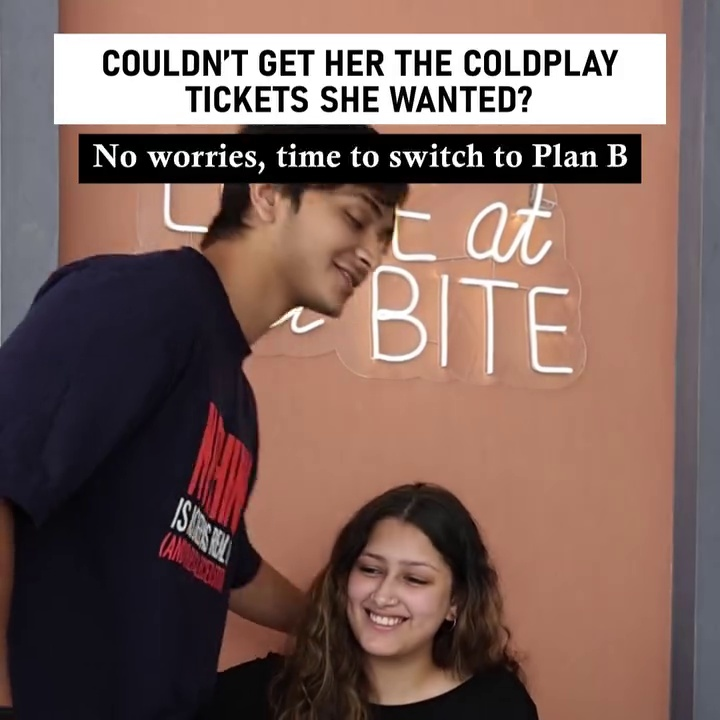

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def process_image(url):
    raw_url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

    try:
        response = requests.get(raw_url)
        img = Image.open(BytesIO(response.content))
        img.show()
    except Exception as e:
        print(f"Error downloading image: {url}, {str(e)}")


url = "https://github.com/Ansumanbhujabal/Influencer_Performance_System/blob/main/influencers/detected_objects_archive/48/man_frame_1.jpg"
process_image(url)


# **Matching the same influencer face in different clusters and then combining the clusters based on match using CLIPModel**

In [ ]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
import numpy as np


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


df = pd.read_excel("Final_Influencer_Data_insights.xlsx")


df['Influencer pic url'] = df['Influencer pic url'].apply(
    lambda url: url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/") if isinstance(url, str) and "github.com" in url else None
)


embeddings_to_clusters = {}


def calculate_clip_embedding(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = clip_processor(images=img, return_tensors="pt")
        embedding = clip_model.get_image_features(**inputs).detach().numpy()
        return embedding
    except Exception as e:
        print(f"Error processing image {image_url}: {e}")
        return None


SIMILARITY_THRESHOLD = 0.83

matching_clusters = []

for index, row in df.iterrows():
    image_url = row['Influencer pic url']
    cluster = row['Influencer Label']
    if not image_url:
        matching_clusters.append(None)
        continue

    embedding = calculate_clip_embedding(image_url)
    if embedding is not None:
        matched_cluster = None
        for stored_embedding, stored_clusters in embeddings_to_clusters.items():
            embedding_reshaped = embedding.reshape(1, -1)
            stored_embedding_reshaped = np.array(stored_embedding).reshape(1, -1)
            similarity = cosine_similarity(embedding_reshaped, stored_embedding_reshaped)[0][0]
            if similarity >= SIMILARITY_THRESHOLD:
                matched_cluster = ", ".join(str(stored_clusters))
                embeddings_to_clusters[stored_embedding].append(cluster)
                break

        if matched_cluster:
            matching_clusters.append(matched_cluster)
        else:

            embeddings_to_clusters[tuple(embedding.flatten())] = [cluster]
            matching_clusters.append(None)
    else:
        matching_clusters.append(None)


df['Matching'] = matching_clusters


output_file = "Final_Influencer_Data_with_CLIP_Matching.xlsx"
df.to_excel(output_file, index=False)
print(f"Processed data saved to {output_file}")


# **Report generation**

In [ ]:
import pandas as pd


df = pd.read_excel("Final_Influencer_Data_insights_up_dec1_t2.xlsx")


html_content = "<html><body><h1>Influencer Performance Report</h1><table border='1'>"
html_content += "<tr><th>Influencer Label</th><th>Influencer Pic</th><th>Average Performance</th><th>Video URL</th></tr>"


for index, row in df.iterrows():

    img_url = row['Influencer Pic URL']


    if isinstance(img_url, str):
        img_url = img_url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    else:
        img_url = ""


    html_content += f"""
    <tr>
        <td>{row['Influencer Label']}</td>
        <td><img src="{img_url}" width="100" height="100"></td>
        <td>{row['Average Performance']}</td>
        <td><a href="{row['Video URL']}">Video Link</a></td>
    </tr>
    """


html_content += "</table></body></html>"


with open("influencer_report_up.html", "w") as f:
    f.write(html_content)

print("HTML report saved.")


HTML report saved.


In [ ]:
import pandas as pd


df = pd.read_excel("Final_Influencer_Data_insights_up_dec1_t2.xlsx")


html_content = """
<html>
<head>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            background-color: #f4f4f4;
        }
        table {
            width: 95%;
            border-collapse: collapse;
            margin: 20px auto;
            background-color: #ffffff;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
        }
        th, td {
            border: 1px solid #dddddd;
            text-align: center;
            padding: 20px;
            font-size: 16px;
        }
        th {
            background-color: #f2f2f2;
            font-size: 18px;
        }
        img {
            width: 150px;
            height: 150px;
            object-fit: cover;
        }
    </style>
</head>
<body>
    <h1 style="text-align:center;">Influencer Performance Report</h1>
    <table>
        <tr>
            <th>Influencer Label</th>
            <th>Influencer Pic</th>
            <th>Average Performance</th>
            <th>Video URL</th>
        </tr>
"""

for index, row in df.iterrows():
    img_url = row['Influencer Pic URL']

    if isinstance(img_url, str):
        img_url = img_url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    else:
        img_url = ""


    html_content += f"""
        <tr>
            <td>{row['Influencer Label']}</td>
            <td><img src="{img_url}" alt="Image Not Found"></td>
            <td>{row['Average Performance']}</td>
            <td><a href="{row['Video URL']}">Video Link</a></td>
        </tr>
    """


html_content += """
    </table>
</body>
</html>
"""


with open("influencer_report_updated.html", "w") as f:
    f.write(html_content)

print("HTML report saved.")


HTML report saved.


# **Performance vs Clsuter At final data insights**




In [4]:
df4=pd.read_excel("/content/Final_Influencer_Data_insights_up_dec1_t2.xlsx")

In [5]:
df4.head()

,Influencer Label,Occurrences,Influencer Pic URL,Average Performance,Video URL
0,3,59,https://raw.githubusercontent.com/Ansumanbhuja...,1.024786,https://fgimagestorage.blob.core.windows.net/f...
1,7,4,https://raw.githubusercontent.com/Ansumanbhuja...,0.803813,https://fgimagestorage.blob.core.windows.net/f...
2,25,3,https://raw.githubusercontent.com/Ansumanbhuja...,1.122567,https://fgimagestorage.blob.core.windows.net/f...
3,45,4,https://raw.githubusercontent.com/Ansumanbhuja...,0.917806,https://fgimagestorage.blob.core.windows.net/f...
4,15,2,https://raw.githubusercontent.com/Ansumanbhuja...,0.827382,https://fgimagestorage.blob.core.windows.net/f...


**Top 10 performers based on score**

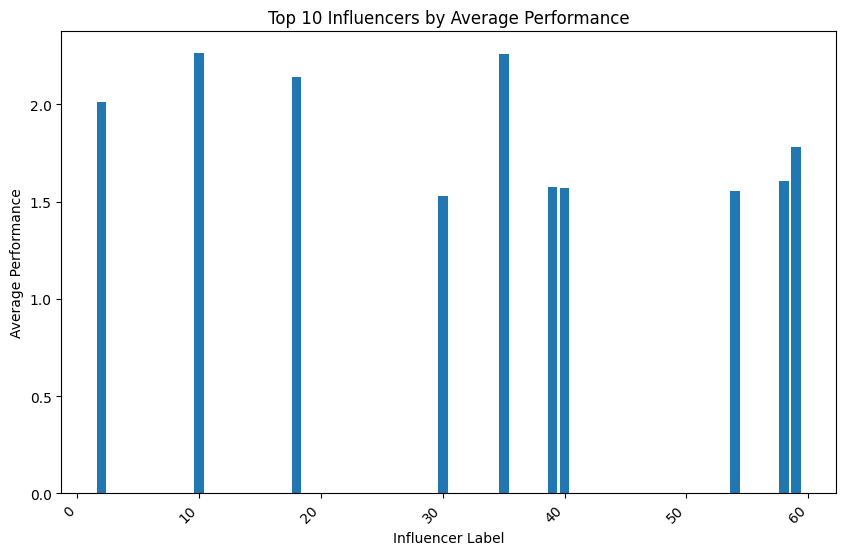

In [6]:
import matplotlib.pyplot as plt

top_10_influencers = df4.sort_values(by=['Average Performance'], ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_influencers['Influencer Label'], top_10_influencers['Average Performance'])
plt.xlabel('Influencer Label')
plt.ylabel('Average Performance')
plt.title('Top 10 Influencers by Average Performance')
_ = plt.xticks(rotation=45, ha='right')

**average performance of each influencer**

<ipython-input-9-8fe2e9213dec>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Influencer Label', y='Average Performance', data=sorted_influencers, palette="viridis", edgecolor="black", linewidth=0.8)


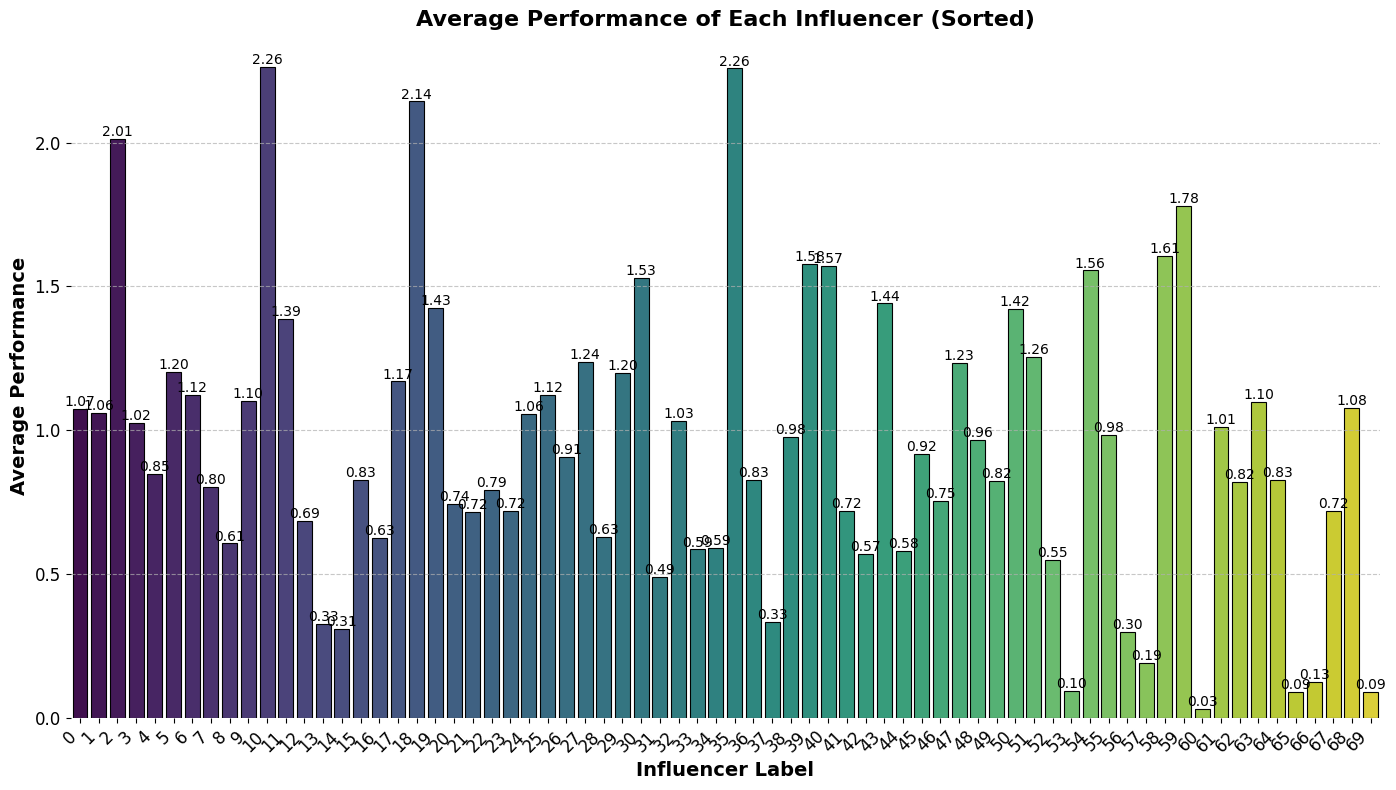

In [9]:

sorted_influencers = df4.sort_values(by='Average Performance', ascending=False)


plt.figure(figsize=(14, 8))
sns.barplot(x='Influencer Label', y='Average Performance', data=sorted_influencers, palette="viridis", edgecolor="black", linewidth=0.8)

plt.xlabel("Influencer Label", fontsize=14, fontweight='bold')
plt.ylabel("Average Performance", fontsize=14, fontweight='bold')
plt.title("Average Performance of Each Influencer (Sorted)", fontsize=16, fontweight='bold')

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine(left=True, bottom=True)


for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')

plt.show()

# **Best Faces Detected**

In [18]:
import pandas as pd
def display_influencer_faces(excel_file, num_faces=9):
    df = pd.read_excel(excel_file)
    for index, row in df.head(num_faces).iterrows():
        influencer_label = row["Influencer Label"]
        avg_performance = row["Average Performance"]
        pic_url = row["Influencer Pic URL"]

        print(f"Influencer Label: {influencer_label}")
        print(f"Average Performance: {avg_performance}")

        try:
            from IPython.display import Image, display
            display(Image(url=pic_url))
        except (KeyError, IndexError, TypeError):
            print("No picture found or invalid URL for this influencer.")

        print("-" * 20)
display_influencer_faces("Final_Influencer_Data_insights_up_dec1_t2.xlsx")

Influencer Label: 3
Average Performance: 1.02478604992305


--------------------
Influencer Label: 7
Average Performance: 0.80381331575


--------------------
Influencer Label: 25
Average Performance: 1.12256666666667


--------------------
Influencer Label: 45
Average Performance: 0.917806254725


--------------------
Influencer Label: 15
Average Performance: 0.8273821321


--------------------
Influencer Label: 22
Average Performance: 0.7929559845


--------------------
Influencer Label: 30
Average Performance: 1.5304


--------------------
Influencer Label: 34
Average Performance: 0.5907609883


--------------------
Influencer Label: 55
Average Performance: 0.9830456907


--------------------
